In [1]:
from obj import *
from parepy_toolbox import *

c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# ============================================================
# 1. Definição dos parâmetros probabilísticos no mesmo formato
# ============================================================

z = {'type': 'normal', 'parameters': {'mean': 100.0, 'std': 0.04 * 100.0}}      # Módulo resistente (4% variação)
fy = {'type': 'lognormal', 'parameters': {'mean': 40.0, 'std': 0.10 * 40.0}}    # Resistência do aço (10% variação)
M_d  = {'type': 'gumbel max', 'parameters': {'mean': 2000.0, 'std': 0.10 * 2000.0}} # Momento solicitante extremo (10%)

vars = [z, fy, M_d]


In [31]:
n_samples = 1000000
n_g = 1
args = None

In [32]:
df, pf, beta = sampling_algorithm_structural_analysis(of_conf, vars, 'lhs', n_samples, n_g, parallel=True, verbose=False, args=args)


In [33]:
print(f"Probabilidade de falha estimada: {pf}")
print(f"Fator de segurança confiável (beta): {beta}")

Probabilidade de falha estimada:       pf_0
0  0.00002
Fator de segurança confiável (beta):     beta_0
0  4.10748


In [33]:
df.head()

,X_0,X_1,X_2,G_0,I_0
0,94.950432,42.041525,1995.214304,1996.646647,0.0
1,104.168301,36.987095,1779.238483,2073.644388,0.0
2,94.391096,43.247941,1969.336037,2112.884467,0.0
3,103.548212,42.324476,2447.563553,1935.060304,0.0
4,97.645458,41.772173,1693.300209,2385.562734,0.0


# Bayesian Model (Henrique)

In [6]:
get_lognormal_params(fy_mean_arith, fy_std_arith)

(0, 0.0997513451195927, 39.80148760839957)

In [34]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

# --- 1. Helper Functions for Parameter Conversion ---
# These mimic your existing logic but output exactly what PyMC expects

def get_lognormal_params(mean_arith, std_arith):
    """
    Converts arithmetic Mean and Std to Lognormal Mu and Sigma.
    (Matches the logic in your 'convert_params_to_scipy')
    """
    # epsilon in your code
    sigma_log = np.sqrt(np.log(1 + (std_arith / mean_arith) ** 2))
    # lambda in your code
    mu_log = np.log(mean_arith) - 0.5 * sigma_log ** 2
    return mu_log, sigma_log

def get_gumbel_max_params(mean_arith, std_arith):
    """
    Converts arithmetic Mean and Std to Gumbel Location (mu) and Scale (beta).
    """
    gamma = 0.5772156649015329
    
    # alpha in your code (Scale) -> PyMC calls this 'beta'
    scale_param = std_arith * np.sqrt(6) / np.pi
    
    # beta in your code (Location) -> PyMC calls this 'mu'
    loc_param = mean_arith - scale_param * gamma
    
    return loc_param, scale_param

# --- 2. Input Definitions ---

# Arithmetic parameters defined by the engineers
# z: Normal
z_mean_arith = 100.0
z_std_arith  = 0.04 * 100.0

# fy: Lognormal
fy_mean_arith = 40.0
fy_std_arith  = 0.10 * 40.0

# Md: Gumbel Max
Md_mean_arith = 2000.0
Md_std_arith  = 0.10 * 2000.0

# --- 3. The PyMC Model ---

with pm.Model() as model:
    # ---------------------------------------------------------
    # A. Variable Definition (Priors)
    # ---------------------------------------------------------
    
    # x[0] = z (Normal)
    # PyMC Normal uses mu/sigma directly
    z = pm.Normal('z', mu=z_mean_arith, sigma=z_std_arith)
    
    # x[1] = fy (Lognormal)
    # Convert arithmetic inputs to underlying Normal params
    fy_mu, fy_sigma = get_lognormal_params(fy_mean_arith, fy_std_arith)
    fy = pm.Lognormal('fy', mu=fy_mu, sigma=fy_sigma)
    
    # x[2] = M_d (Gumbel Max)
    # Convert arithmetic inputs to Location/Scale
    # PyMC Gumbel: mu=Location, beta=Scale
    md_loc, md_scale = get_gumbel_max_params(Md_mean_arith, Md_std_arith)
    Md = pm.Gumbel('Md', mu=md_loc, beta=md_scale)
    
    # ---------------------------------------------------------
    # B. Limit State Function (Deterministic)
    # ---------------------------------------------------------
    # This tracks the value of G for every sample
    G = pm.Deterministic('G', z * fy - Md)
    
    # ---------------------------------------------------------
    # C. Simulation (Vectorized Sampling)
    # ---------------------------------------------------------
    # We use sample_prior_predictive because we are calculating 
    # the probability based on known input parameters (Monte Carlo).
    # This is incredibly fast compared to Python loops.
    # n_samples = 1_000_000
    # trace = pm.sample_prior_predictive(samples=n_samples)


In [41]:
n_samples = 100000
with model:
    trace=pm.sample(draws=n_samples,tune=100,cores=12,nuts_sampler='nutpie')

Progress,Draws,Divergences,Step Size,Gradients/Draw
,100100,0,0.85,7
,100100,1,0.89,3
,100100,1,0.86,3
,100100,0,0.79,7
,100100,1,0.76,3
,100100,1,0.82,3
,100100,0,0.77,3
,100100,0,0.68,7
,100100,0,0.82,3
,100100,0,0.83,3


STRUCTURAL RELIABILITY RESULTS (PyMC)
Simulations       : 100000
Failures (G < 0)  : 37
Prob. of Failure  : 0.000031 (0.0031%)
Reliability Index : 4.2038


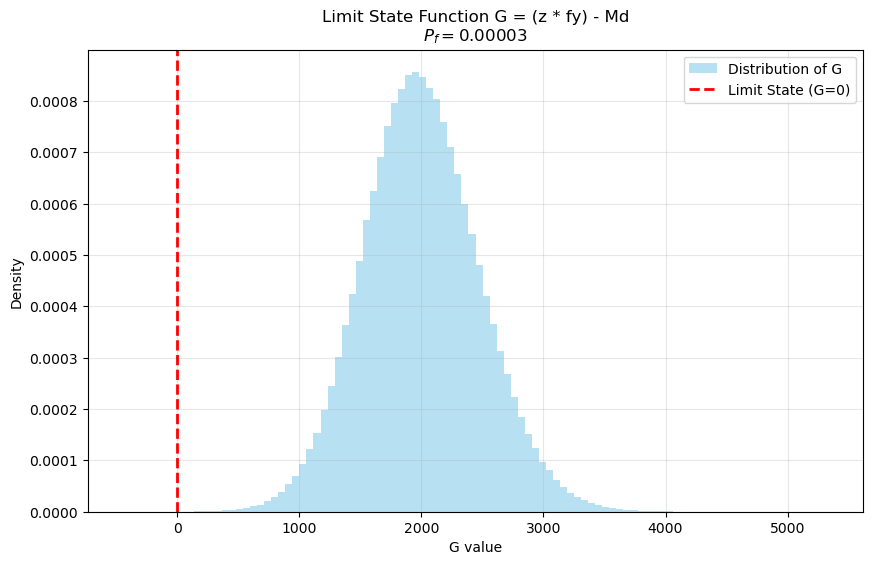

In [42]:

# --- 4. Analysis and Visualization ---

# Extract the sampled data for G
# Shape comes out as (chains, draws), we flatten it to 1D array
g_samples = trace.posterior['G'].values.flatten()

# Calculate Failure Probability (Count where G < 0)
failures = np.sum(g_samples < 0)
pf = failures / len(g_samples)
reliability_beta = -np.mean(g_samples<0) # Rough approximation or calculate via Inverse CDF
# Better Beta Calculation: (Mean_G / Std_G)
mu_G = np.mean(g_samples)
std_G = np.std(g_samples)
beta_index = mu_G / std_G

print(f"=================================================")
print(f"STRUCTURAL RELIABILITY RESULTS (PyMC)")
print(f"=================================================")
print(f"Simulations       : {n_samples}")
print(f"Failures (G < 0)  : {failures}")
print(f"Prob. of Failure  : {pf:.6f} ({pf*100:.4f}%)")
print(f"Reliability Index : {beta_index:.4f}")
print(f"=================================================")

# Plotting
plt.figure(figsize=(10, 6))

plt.hist(g_samples, bins=100, density=True, alpha=0.6, color='skyblue', label='Distribution of G')
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Limit State (G=0)')
plt.title(f'Limit State Function G = (z * fy) - Md\n$P_f = {pf:.5f}$')
plt.xlabel('G value')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()